# **PACKET BASED INTRUSION DETECTION ON UNSW-NB15 DATASET**

## **Environment Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Importing Libraries**

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import imblearn
import sklearn
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## **Load Data**
Datasets with 2 different CSV files, each contains same type of attack data at different times.

In [3]:

# Load UNSW_NB15 Train dataset
UTrain = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Datasets/UNSW_NB15_training-set.csv')

# Load UNSW_NB15 Test dataset
UTest = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Datasets/ UNSW_NB15_testing-set.csv')


UTrain.shape, UTest.shape

((175341, 45), (82332, 45))

In [4]:
combinedData = pd.concat([UTrain, UTest]).drop(['id'],axis=1)

In [5]:
combinedData.tail(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
82329,0.000000,arp,-,INT,1,0,46,0,0.0000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.0000,0,...,1,1,0,0,0,1,1,1,Normal,0
82331,0.000009,udp,-,INT,2,0,104,0,111111.1072,254,...,1,1,0,0,0,1,1,0,Normal,0


In [6]:
combinedData.shape

(257673, 44)

In [7]:
combinedData.dtypes.value_counts()

int64      29
float64    11
object      4
dtype: int64

Some general info about the dataset. It contains roughly 175341 records across 45 columns. Data consists of mostly int64 and float64 types and  four object type.

## **Data Cleaning**
This section contains data cleaning code. We go through the process of renaming columns, removing NaN to get the data ready for visualization and model training.

### Renaming columns

In [8]:
# Removing whitespaces in column names.
attacks = [col.replace(' ', '') for col in combinedData.columns]
combinedData.columns = attacks

In [9]:
# lets see that 'subclass' column contains some wierd characters. 
combinedData["attack_cat"].unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

### Removing NULL values

Checking for any null values in dataset and dropping such values so that our models receive correct dataset in input for training

In [10]:
# Checking if there are any NULL values in the dataset.
combinedData.isnull().values.any()

False

In [11]:
# Checking which column/s contain NULL values.
[col for col in combinedData if combinedData[col].isnull().values.any()]

[]

checking for any values containing - in service column

In [12]:
combinedData[combinedData['service']=='-']

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0
5,0.380537,tcp,-,FIN,10,6,534,268,39.417980,254,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


replacing - values with nan for service column

In [13]:
combinedData['service'].replace('-',np.nan,inplace=True)

finding totoal nan values in dataset again

In [14]:
combinedData.isnull().sum()

dur                       0
proto                     0
service              141321
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm          0
ct_dst_src_ltm      

Dataset shape before removing nan values

In [15]:
combinedData.shape

(257673, 44)

Removing rows with nan values from dataset

In [16]:
combinedData.dropna(inplace=True)

Dataset shape after removing nan values

In [17]:
combinedData.shape

(116352, 44)

In [18]:
combinedData.isnull().any().any()

False

Dropping 'label' column in packet based approach as we need attack category and there is no need of 'label' category

In [19]:
#for packet based approachwe need attack category and  no need of label category, 
combinedData.drop(['label'],axis=1,inplace=True)
combinedData.shape

(116352, 43)

## **Data Visualization**

This section is performing data visualization for understanding the dataset in an artistic manner

In [20]:
# There are 8 different type of attacks apart from normal in Dataset 
print(combinedData['attack_cat'].unique())
len(combinedData['attack_cat'].unique())

['Normal' 'Backdoor' 'Fuzzers' 'Reconnaissance' 'Exploits' 'Analysis'
 'DoS' 'Worms' 'Generic']


9

Visualizing dataset to find out which attack type has more impact

In [21]:
combinedData['attack_cat'].value_counts()

Generic           57956
Normal            29113
Exploits          21480
DoS                2508
Fuzzers            2266
Reconnaissance     2207
Analysis            564
Worms               148
Backdoor            110
Name: attack_cat, dtype: int64

Creating new dataframe for multi class labels and encoding the labels with integers (0 - 8)

In [22]:
# creating a dataframe with multi-class labels ()
multi_data = combinedData.copy()
multi_label = pd.DataFrame(multi_data.attack_cat)

In [23]:
# label encoding (0,1,2,3,4,5,6,7,8) multi-class labels ('Normal' 'Backdoor' 'Fuzzers' 'Reconnaissance' 'Exploits' 'Analysis' 'DoS' 'Worms' 'Generic')
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

In [24]:
np.save("/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Labels/le_classes.npy",le2.classes_,allow_pickle=True)

Visualizing multi class labels using Pie Chart

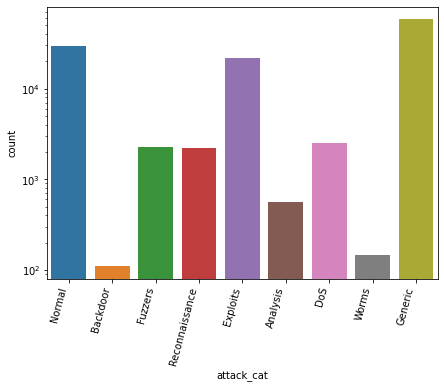

In [25]:
#lets see which attack is having more impact on dataset
plt.figure(figsize=(7,5))
g = sns.countplot( data = multi_data, x = 'attack_cat', palette="tab10")
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=75, ha="right")
plt.savefig('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Images/various_attacks.png')
plt.show()

## **Function to encode string features**

This section is performing the encoding of string features which is required for nerual network training. As we majority of features in numerical form, we want the string features to have some numerical values so that neural network can train on all features including string features.

Separating Features and target for Model training

In [26]:
XX = combinedData.iloc[:,:-1].values
YY = combinedData.iloc[:,-1].values
YY = YY.reshape(-1,1)
print([XX.shape, YY.shape])
YY

[(116352, 42), (116352, 1)]


array([['Normal'],
       ['Normal'],
       ['Normal'],
       ...,
       ['Normal'],
       ['Normal'],
       ['Normal']], dtype=object)

Visualizing string features

In [27]:
combinedData.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
11,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,62,...,1,1,2,0,0,0,1,1,0,Normal
15,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,254,...,1,1,4,0,0,0,2,1,0,Normal
17,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,62,...,1,1,2,0,0,1,1,3,0,Normal
21,0.338017,tcp,http,FIN,10,6,998,268,44.376468,254,...,1,1,1,0,0,1,2,3,0,Normal


Performing encoding of string features

In [28]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder()
ohe = OneHotEncoder()

XX[:,1] = encoder.fit_transform(XX[:,1])
XX[:,2] = encoder.fit_transform(XX[:,2])
XX[:,3] = encoder.fit_transform(XX[:,3])

yy = encoder.fit_transform(YY).reshape(-1,1)
YY = ohe.fit_transform(yy).toarray()
XX.shape, YY.shape
YY

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [29]:
combinedData.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat'],
      dtype='object')

In [30]:
cols_ = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

In [31]:
dataX = pd.DataFrame(XX,columns=cols_)
dataY = pd.DataFrame(yy)
dataY

,0
0,6
1,6
2,6
3,6
4,6
...,...
116347,6
116348,6
116349,6
116350,6


## **Feature Selection**
Since there is such a large number of features, it is possible that some features are redundant. Let us print a correlation matrix

In [32]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import itertools    

model_ = DecisionTreeClassifier()

# create RFE model and select 15 attributes
rec = RFE(model_, n_features_to_select = 15)
rec = rec.fit(dataX, dataY)

# summarize the selection of the attributes
featuresMap = [(x, n) for x, n in itertools.zip_longest(rec.get_support(), dataX.columns)]
selectedFeatures = [n for x, n in featuresMap if x == True]

print(selectedFeatures)

['dpkts', 'sbytes', 'dbytes', 'sttl', 'sload', 'dinpkt', 'sjit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_dst']


Selecting Features

In [59]:
Xdata = dataX[selectedFeatures]
X = Xdata[selectedFeatures]
print('15 selected features \n')
X.head()

15 selected features 



,dpkts,sbytes,dbytes,sttl,sload,dinpkt,sjit,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,ct_srv_dst
0,12,628,770,62,2740.178955,90.235726,259.080172,1107119177,1047442890,0.0,0.0,0.0,52,64,1
1,28,56329,2212,62,211825.125,75.092445,3253.278833,1824722662,860716719,0.13114,0.052852,0.078288,909,79,1
2,0,138,0,254,276000000.0,0.0,0.0,0,0,0.0,0.0,0.0,69,0,1
3,8,860,1096,62,15733.46582,47.669145,2124.837873,3882971404,3084071099,0.120313,0.059201,0.061112,86,137,3
4,6,998,268,254,21277.03711,56.579801,1928.55071,2665974075,3521361798,0.154433,0.055109,0.099324,100,45,3


## **Over Sampling**

In [34]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
Xres, Yres = sm.fit_resample(Xdata, dataY)

## **Dataset Splitting**
The next step is to split training and testing data. For this we will use sklearn function train_test_split(). This step is important so we can have representative data for evaluating our model. Both train and test samples should contain similar data variance.

In [35]:
from sklearn.model_selection import train_test_split
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().
i_train, i_test, j_train, j_test = train_test_split(Xres, Yres, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)

In [36]:
i_train.shape, j_train.shape, i_test.shape, j_test.shape    # test is larger... good 

((365122, 15), (365122, 1), (156482, 15), (156482, 1))

## **Scaling Numerical Attributes**
The next few cells contain the code for scaling the data into the size adequate for the Models.

In [37]:
# ?? why transformation here
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
i_train = sc.fit_transform(i_train)
i_test = sc.transform(i_test)
i_train.shape, i_test.shape

((365122, 15), (156482, 15))

## **Machine-Learning model training**

importing required libraries for ml model

In [38]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error,roc_auc_score,cohen_kappa_score)
import sklearn.metrics as metrics

### Training four base learners: decision tree, random forest, XGBoost

#### Apply DT

Training Decision Tree

Accuracy of Decision Tree: 0.9335898058562646
                precision    recall  f1-score   support

      Analysis       0.97      0.99      0.98     17431
      Backdoor       0.98      0.99      0.99     17392
           DoS       0.80      0.82      0.81     17466
      Exploits       0.80      0.76      0.78     17378
       Fuzzers       0.96      0.96      0.96     17631
       Generic       0.99      0.99      0.99     17445
        Normal       0.95      0.94      0.95     17426
Reconnaissance       0.94      0.95      0.95     17178
         Worms       0.99      1.00      0.99     17135

      accuracy                           0.93    156482
     macro avg       0.93      0.93      0.93    156482
  weighted avg       0.93      0.93      0.93    156482



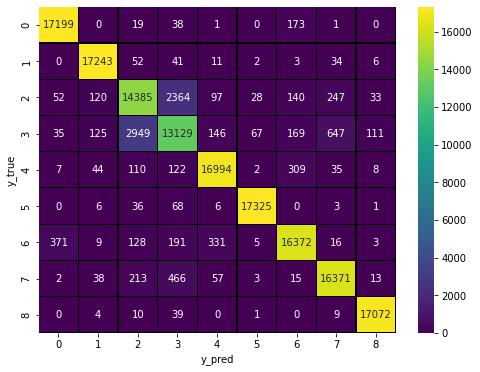

In [39]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(i_train, j_train) 

y_predict=dt.predict(i_test)
y_true=j_test

dt_score=dt.score(i_test, j_test)
print('Accuracy of Decision Tree: '+ str(dt_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply RF

Training Random Forest

Accuracy of Random Forest: 0.9599059316726525
                precision    recall  f1-score   support

      Analysis       0.97      1.00      0.99     17431
      Backdoor       0.99      1.00      1.00     17392
           DoS       0.87      0.92      0.89     17466
      Exploits       0.91      0.82      0.86     17378
       Fuzzers       0.97      0.99      0.98     17631
       Generic       1.00      0.99      0.99     17445
        Normal       0.99      0.94      0.97     17426
Reconnaissance       0.94      0.98      0.96     17178
         Worms       0.99      1.00      1.00     17135

      accuracy                           0.96    156482
     macro avg       0.96      0.96      0.96    156482
  weighted avg       0.96      0.96      0.96    156482



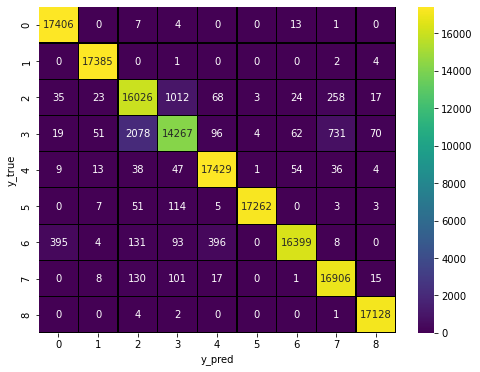

In [40]:
##@title  { vertical-output: true, display-mode: "both" }
rf = RandomForestClassifier(random_state = 0)
rf.fit(i_train, j_train) 

y_predict=rf.predict(i_test)
y_true=j_test

rf_score=rf.score(i_test, j_test)
print('Accuracy of Random Forest: '+ str(rf_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply XGBoost

Training XGBoost

                precision    recall  f1-score   support

      Analysis       0.89      0.95      0.92     17431
      Backdoor       0.73      0.42      0.53     17392
           DoS       0.45      0.42      0.43     17466
      Exploits       0.60      0.65      0.62     17378
       Fuzzers       0.79      0.91      0.84     17631
       Generic       1.00      0.99      0.99     17445
        Normal       1.00      0.85      0.92     17426
Reconnaissance       0.76      0.91      0.83     17178
         Worms       0.75      0.87      0.81     17135

      accuracy                           0.77    156482
     macro avg       0.77      0.77      0.77    156482
  weighted avg       0.77      0.77      0.77    156482



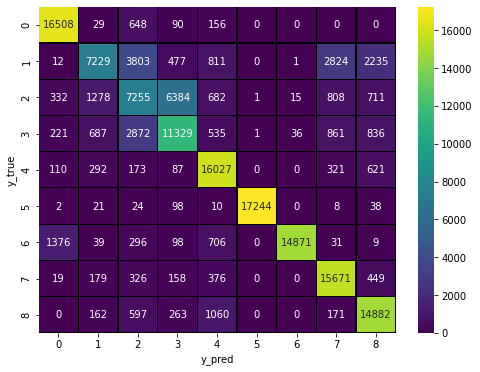

In [41]:
##@title  { vertical-output: true, display-mode: "both" }
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(i_train,j_train)

y_predict=xg.predict(i_test)
y_true=j_test

xg_score=xg.score(i_test, j_test)
cr = print(metrics.classification_report(y_true, y_predict, target_names=le2.classes_))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## **Deep-Learning Model Training**
In this stage we go by explaning parts of the network and its hyperparameters.

### Bi-directional LSTM Model


In [42]:
#importing lobraries
import keras
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense,Dropout, BatchNormalization, Activation, Bidirectional, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

In [43]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_res, y_res = sm.fit_resample(X,YY)

In [44]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_res, y_res,  train_size=0.7, test_size=0.3,  random_state = 1, shuffle=True)
print([Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape])

[(365122, 15), (156482, 15), (365122, 9), (156482, 9)]


In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
Xtrain.shape, Xtest.shape

((365122, 15), (156482, 15))

### Reshaping our data into 3D, which is required format of LSTM input

In [46]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1], 1)
Xtrain.shape, Xtest.shape

((365122, 15, 1), (156482, 15, 1))

### Structure of our BiLSTM

In [47]:
timesteps = 30

In [48]:
blstm_model = tf.keras.Sequential()
blstm_model.add(Bidirectional(LSTM(60, return_sequences=True, activation= 'relu', input_shape=(Xtrain.shape[1], timesteps, 1))))
blstm_model.add(Bidirectional(LSTM(60,return_sequences= False, activation= 'relu')))
blstm_model.add(tf.keras.layers.Dropout(0.2))
blstm_model.add(Dense(9, activation= 'softmax'))
blstm_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history2 = blstm_model.fit(Xtrain, Ytrain,  epochs=10, validation_split=0.3, batch_size=700).history
#model.summary()

Epoch 1/10
366/366 [==============================] - 130s 340ms/step - loss: 1.2569 - accuracy: 0.5250 - val_loss: 0.9427 - val_accuracy: 0.6602
Epoch 2/10
366/366 [==============================] - 123s 336ms/step - loss: 0.8783 - accuracy: 0.6849 - val_loss: 0.8159 - val_accuracy: 0.7062
Epoch 3/10
366/366 [==============================] - 124s 338ms/step - loss: 0.7450 - accuracy: 0.7366 - val_loss: 0.7014 - val_accuracy: 0.7493
Epoch 4/10
366/366 [==============================] - 124s 338ms/step - loss: 0.6785 - accuracy: 0.7599 - val_loss: 0.6201 - val_accuracy: 0.7799
Epoch 5/10
366/366 [==============================] - 123s 336ms/step - loss: 0.6310 - accuracy: 0.7766 - val_loss: 0.6121 - val_accuracy: 0.7869
Epoch 6/10
366/366 [==============================] - 123s 337ms/step - loss: 0.5981 - accuracy: 0.7868 - val_loss: 0.6448 - val_accuracy: 0.7667
Epoch 7/10
366/366 [==============================] - 125s 343ms/step - loss: 0.5734 - accuracy: 0.7961 - val_loss: 0.5612 -

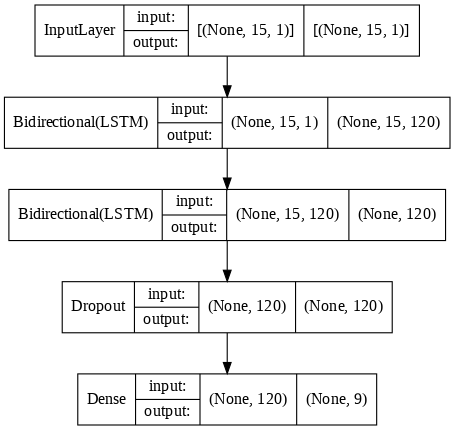

In [49]:
plot_model(blstm_model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

Evaluating our trained BiLSTM

4891/4891 [==============================] - 46s 9ms/step - loss: 0.4881 - accuracy: 0.8261
Accuracy of BLSTM: 0.8261397480964661
Precision of BLSTM: 0.8267599540840296
Recall of BLSTM: 0.8261397477026111
F1-score of BLSTM: 0.823854556436268
                precision    recall  f1-score   support

      Analysis       0.86      0.96      0.91     17431
      Backdoor       0.81      0.73      0.77     17392
           DoS       0.57      0.57      0.57     17466
      Exploits       0.68      0.58      0.63     17378
       Fuzzers       0.91      0.89      0.90     17631
       Generic       1.00      0.99      0.99     17445
        Normal       1.00      0.85      0.92     17426
Reconnaissance       0.80      0.91      0.85     17178
         Worms       0.81      0.96      0.88     17135

      accuracy                           0.83    156482
     macro avg       0.83      0.83      0.82    156482
  weighted avg       0.83      0.83      0.82    156482



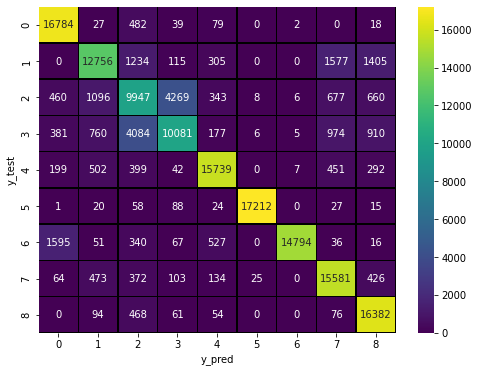

In [50]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
blstm_score = blstm_model.evaluate(Xtest, Ytest)
y_pred=blstm_model.predict(Xtest)
b_predict=np.argmax(y_pred, axis=1)
b_test=np.argmax(Ytest, axis=1)


print('Accuracy of BLSTM: '+ str(blstm_score[1]))

precision,recall,fscore,none= precision_recall_fscore_support(b_test,np.round(b_predict), average='weighted') 
print('Precision of BLSTM: '+(str(precision)))
print('Recall of BLSTM: '+(str(recall)))
print('F1-score of BLSTM: '+(str(fscore)))
print(metrics.classification_report(b_test, np.round(b_predict), target_names=le2.classes_))

cm=confusion_matrix(b_test, np.round(b_predict))
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.show()

### Accuracy Curve of our trained BiLSTM

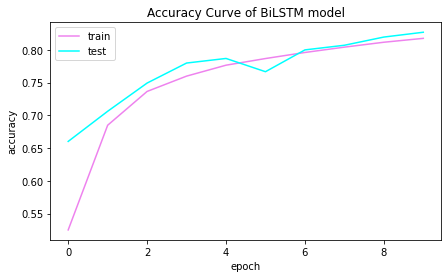

In [51]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of accuracy vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['accuracy'], 'violet')
plt.plot(history2['val_accuracy'],'cyan')

plt.title('Accuracy Curve of BiLSTM model')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper left');

### Loss Curve of our trained BiLSTM

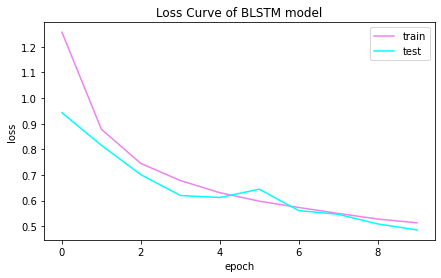

In [52]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of loss vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['loss'], 'violet')
plt.plot(history2['val_loss'], 'cyan')

plt.title('Loss Curve of BLSTM model')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper right');

## **Models Comparision**
The table below tabulates all the score accuracies from each model for a clear comparision.

In [53]:
result = pd.DataFrame({ 'Classifiers': ['DecisionTree Classifier', 'RandomForest Classifier','GradientBoosting Classifier', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})

result

,Classifiers,Score
0,DecisionTree Classifier,0.933590
1,RandomForest Classifier,0.959906
2,GradientBoosting Classifier,0.773354
3,Bidirectional LSTM,0.826140


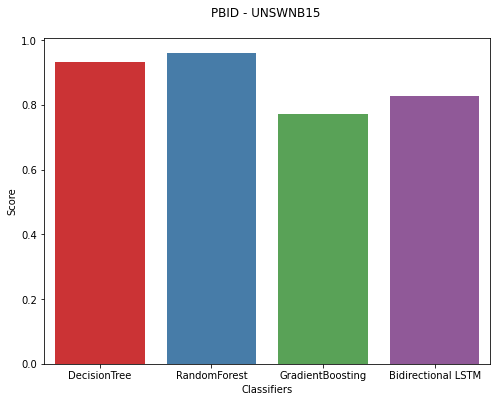

In [54]:
chart = pd.DataFrame({ 'Classifiers': ['DecisionTree', 'RandomForest','GradientBoosting', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})
plt.figure(figsize=(8,6))
ax=sns.barplot(data = chart, x = 'Classifiers', y = 'Score', palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), )
plt.title('PBID - UNSWNB15 \n ', fontsize=12)
#plt.legend([],[], frameon=True)
plt.show()

From these tested models, the results table shows that Random Forest classifier boast a 94% accuracy. 
The Deep Learning Models are even not far behind which had 92% around for  BLSTM.

In conclusion, the Random Forest classifier out performs all the models in detecting intrusion on the network. DecisionTree classifier are a close second in detecting intrusions and giving reliable predictions.

Finally To evaluate more about these models, the ROC curve and Calibration plots for multi-class classification need to be implemented.

### **Performance Test**

As our problem is about detecting intrusions. So what we require is more recall than precision of our model. Let's explain this, recall is important where false negative is more important than false positive. Here as false negative case ( means a real instrusion not detected ) is costly and we cannot afford to let go the intrusion undetected. And precision is important where false positive is more imporant than false negative.

So the class which has more recall is class 3, as it has more recall and precision than other clasess as observed from figure below.

Importing required libraries

Separating features and target

and training one vs rest classifier


## **Plot the ROC Curve**

Basically, ROC curve is an evaluation technique for classification problems. It plots sensivity against specificity. Senstivity is another name for recall which is true positive rate and specificity is false negative rate.

We desire to maximize these two values. If we maximize senstivity, the specificity lowers and vice versa. It depends on scenario which one to prefer.

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc

In [56]:
X_train, X_test, y_train, y_test = train_test_split(Xdata, dataY, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)
classes=le2.classes_

In [57]:
RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train,y_train)
y_pred =RF.predict(X_test)
pred_prob = RF.predict_proba(X_test)

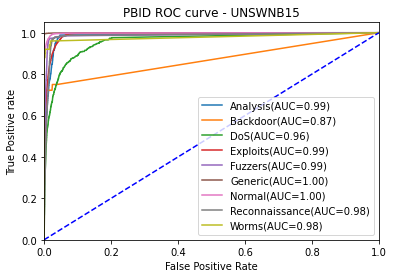

In [58]:
from sklearn.preprocessing import label_binarize
#binarize the y_values

y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], 
             label='%s(AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('PBID ROC curve - UNSWNB15')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()